### EDA - Exploiratory data analysis

Find a way to programatically help the DS to identify if the dataset is good for the problem.
Help with understanding and helping with necessary actions to make the dataset good for training models and solving the problem.


Claro! Aqui está o conteúdo formatado como um `README.md`, ideal para documentar boas práticas ao lidar com distribuição desbalanceada em problemas de **classificação** e **regressão** em machine learning:

```markdown
# ⚖️ Considerações sobre Distribuição Desbalanceada em Modelos de Machine Learning

Este documento aborda os riscos, consequências e estratégias de mitigação ao colocar em produção modelos de **classificação** e **regressão** treinados com dados desbalanceados ou com distribuição enviesada do alvo.

---

## 📊 Classificação com Dataset Desbalanceado

### ⚠️ Riscos

- **Previsão enviesada para a classe majoritária**  
  O modelo tende a favorecer a classe com mais exemplos, ignorando casos críticos da minoria.

- **Métricas ilusórias**  
  Alta acurácia pode mascarar desempenho ruim na classe minoritária.

### 🚨 Consequências

- Falha em detectar fraudes, falhas ou eventos raros.
- Reclamações de usuários por erros em casos críticos.
- Perda de receita e riscos regulatórios por viés.

### 🛠️ Estratégias de Mitigação

- **Reamostragem**: SMOTE, ADASYN, undersampling controlado.
- **Ajuste de pesos**: penalização maior para erros na classe minoritária.
- **Métricas adequadas**: F1-score, AUC-ROC, precision-recall.
- **Modelos custo-sensíveis**: decision trees com penalidades por classe.
- **Validação estratificada**: preserva proporção de classes nos folds.

### 📈 Monitoramento em Produção

- Acompanhar métricas específicas da classe minoritária.
- Detectar drift e realizar retreinamentos periódicos.

---

## 📉 Regressão com Alvo Enviesado

### ⚠️ Riscos

- **Centralização das predições**  
  O modelo subestima picos ou eventos raros.

- **Métricas mascaradas**  
  MAE/MSE dominados por pontos frequentes.

- **Sensibilidade a outliers**  
  MSE pode ser distorcido por valores extremos.

### 🚨 Consequências

- Subestimação de custos ou riscos elevados.
- Decisões erradas em situações críticas.
- Frustração de usuários em cenários extremos.

### 🛠️ Estratégias de Mitigação

- **Transformação do alvo**: log, Box–Cox, Yeo–Johnson.
- **Reamostragem por faixa (binning)**: balancear amostras por faixa de valor.
- **Função de perda ponderada**: pesos inversamente proporcionais à densidade.
- **Regressão quantílica**: prever diferentes quantis (0.1, 0.5, 0.9).
- **Validação estratificada por faixa de alvo**.

### 📈 Monitoramento em Produção

- Acompanhar erro por faixa de valor.
- Monitorar resíduos e detectar drift nas caudas.

---

## 🚀 Próximos Passos Recomendados

- Avaliar fairness e viés por subgrupos.
- Implementar explicabilidade (SHAP, LIME).
- Testar regressão quantílica e aprendizado robusto (Huber loss).
- Integrar conformal prediction para intervalos de confiança.
- Expandir pipeline MLOps com testes, alertas e retreinamento automático.

---

> Este guia é útil para cientistas de dados, engenheiros de machine learning e equipes de MLOps que desejam garantir robustez e justiça em modelos colocados em produção.
```

Se quiser que eu adapte esse conteúdo para um projeto específico, inclua badges, links, ou estrutura de tópicos adicionais, posso personalizar ainda mais!

In [2]:
import pandas

In [9]:
import os
import argparse
import pandas as pd
import mlflow
import mlflow.sklearn
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [6]:
# load the data

credit_df = pd.read_csv(
    ".\\data\\processed\\default_of_credit_card_clients.csv",
    index_col=0,
)

train_df, test_df = train_test_split(
    credit_df,
    test_size=0.25,
)

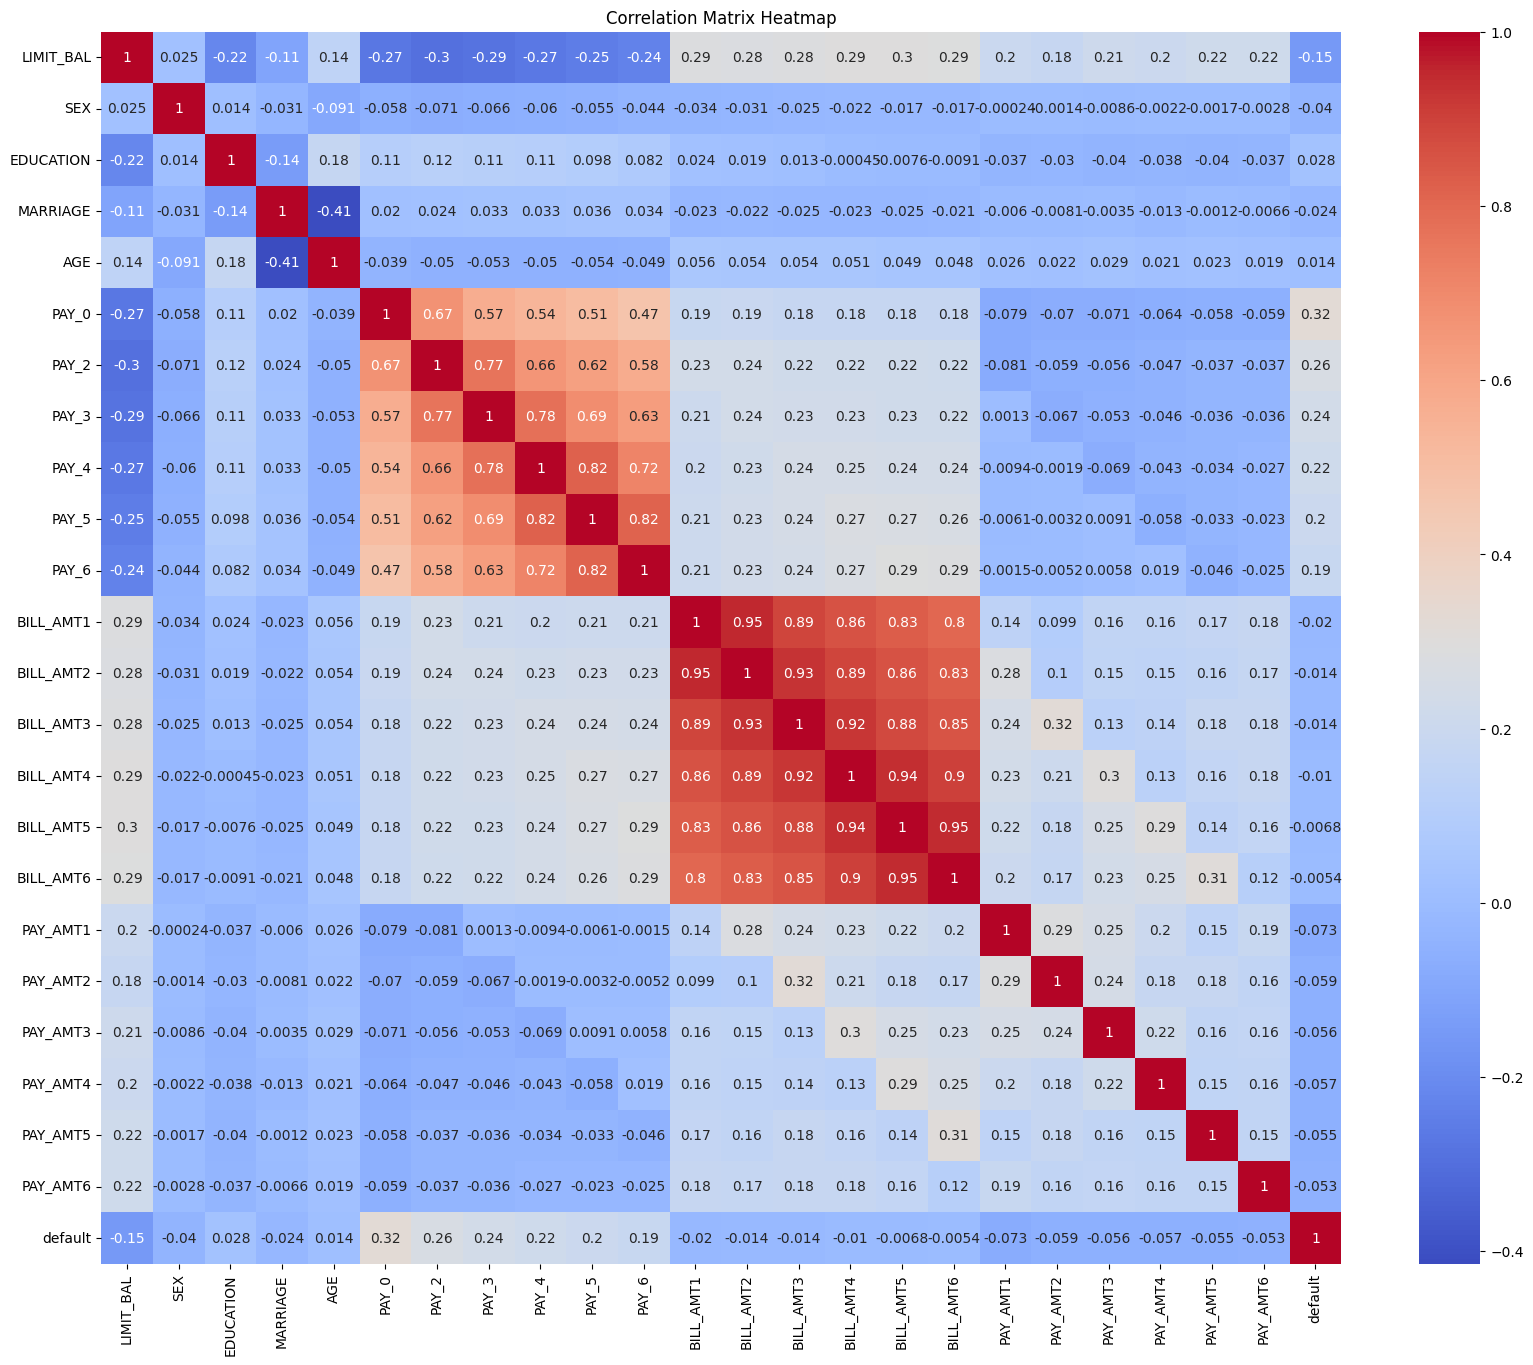

In [13]:
# run correlation matrix and plot
f, ax = plt.subplots(figsize=(20, 16))
corr_matrix = credit_df.corr()
# Visualize the correlation matrix as a heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
            
# sns.heatmap(corr_matrix, mask=np.zeros_like(corr_matrix, dtype=np.bool),
#             cmap=sns.diverging_palette(220, 10, as_cmap=True),
#             square=True, ax=ax)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [4]:
train_df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
14166,10000,1,1,2,38,0,0,-1,-1,-1,...,390,0,780,1000,390,390,0,780,0,0
4005,20000,2,3,1,42,-1,-1,-1,-1,-1,...,7312,1868,1470,637,11869,7314,2274,1470,2200,0
22966,30000,2,1,2,25,0,0,0,0,0,...,29222,28451,27270,1448,1600,1500,1000,1000,1200,0
8997,80000,1,2,2,31,8,7,6,5,4,...,97622,88878,80518,0,0,0,0,0,0,0
20744,450000,1,1,1,45,-1,-1,-1,0,0,...,46367,46191,20019,700,46727,1400,924,400,16608,1


In [15]:
# Extracting the label column
y_train = train_df.pop("default")

# convert the dataframe values to array
X_train = train_df.values

# Extracting the label column
y_test = test_df.pop("default")

# convert the dataframe values to array
X_test = test_df.values

In [16]:

# set name for logging
mlflow.set_experiment("Develop on cloud tutorial")
# enable autologging with MLflow
mlflow.sklearn.autolog()

2025/07/17 22:01:40 INFO mlflow.tracking.fluent: Experiment with name 'Develop on cloud tutorial' does not exist. Creating a new experiment.


In [17]:
# Train Gradient Boosting Classifier
print(f"Training with data of shape {X_train.shape}")

mlflow.start_run()
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))
# Stop logging for this model
mlflow.end_run()

Training with data of shape (22500, 23)


2025/07/17 22:02:06 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


              precision    recall  f1-score   support

           0       0.85      0.95      0.90      5867
           1       0.69      0.38      0.49      1633

    accuracy                           0.83      7500
   macro avg       0.77      0.67      0.70      7500
weighted avg       0.81      0.83      0.81      7500



In [18]:
# Train  AdaBoost Classifier
from sklearn.ensemble import AdaBoostClassifier

print(f"Training with data of shape {X_train.shape}")

mlflow.start_run()
ada = AdaBoostClassifier()

ada.fit(X_train, y_train)

y_pred = ada.predict(X_test)

print(classification_report(y_test, y_pred))
# Stop logging for this model
mlflow.end_run()

2025/07/17 22:03:47 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


Training with data of shape (22500, 23)
              precision    recall  f1-score   support

           0       0.84      0.96      0.90      5867
           1       0.70      0.35      0.47      1633

    accuracy                           0.83      7500
   macro avg       0.77      0.65      0.68      7500
weighted avg       0.81      0.83      0.80      7500



In [19]:
X_test

array([[200000,      2,      2, ...,   1098,   1500,   1000],
       [ 50000,      1,      1, ...,    390,  23269,   1500],
       [420000,      1,      1, ...,  22285,  13270,  10683],
       ...,
       [ 20000,      1,      2, ...,    595,   1000,   1000],
       [ 50000,      1,      2, ...,      0,      0,      0],
       [ 30000,      2,      2, ...,   1001,   1030,   1059]],
      shape=(7500, 23))

In [ ]:
y_pred_proba = clf.predict_proba(X_test)


In [23]:
y_pred_proba

array([[0.90646193, 0.09353807],
       [0.79573356, 0.20426644],
       [0.95420531, 0.04579469],
       ...,
       [0.83596321, 0.16403679],
       [0.77059513, 0.22940487],
       [0.85070376, 0.14929624]], shape=(7500, 2))

In [27]:
# Train  AdaBoost Classifier
from sklearn.ensemble import AdaBoostClassifier

print(f"Training with data of shape {X_train.shape}")

mlflow.start_run()
ada = AdaBoostClassifier()

ada.fit(X_train, y_train)

y_pred = ada.predict_proba(X_test)

# Apply a custom threshold (0.7 in this case)
y_pred_custom = (y_pred_proba[:, 1] >= 0.1).astype(int)

print(classification_report(y_test, y_pred_custom))

# Stop logging for this model
mlflow.end_run()


Training with data of shape (22500, 23)


2025/07/17 22:36:21 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


              precision    recall  f1-score   support

           0       0.93      0.33      0.49      5867
           1       0.27      0.91      0.42      1633

    accuracy                           0.46      7500
   macro avg       0.60      0.62      0.45      7500
weighted avg       0.79      0.46      0.47      7500

